In [80]:
#!pip install pygad

Modified version of pygad samples. https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad <br>
Model inspired and modified from http://uhurumkate.blogspot.com/2018/06/tiny-model-for-mnist-dataset.html

You're highly encouraged to use a GPU as it's going to spent most resources on predicting and calculating loss. Please also note that pygad library only use CPU paralleal in some cases.

In [81]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import losses, datasets, layers, optimizers, Sequential, metrics
import pygad.kerasga
import numpy
import math
import pygad

# Hyper param

In [82]:
acc_meter = tf.keras.metrics.Accuracy()

#Instead of training a entire dataset, do small batches.
sgd_like = True

#introduce new population when stucked. Often time it'll stuck in local optima.
introduce_new_pop = False

#increase batch size when stcuked.
dynamic_batch_size = True

In [83]:
#num cycles
num_generations = 5000

#num soltions
num_solution= 20

#the following two param only works if introduce_new_pop = True
#Maxium cycles stuck before introducing new population to the pool.
max_cycles_stucked = 20

#The follow two param have effect only when sgd_like = True
#number of cycles you want on a single batch. 
epoch = 5
#number of samples per batch
batch_size = 3500

#number batch increase feed into prediction. only have effect if sgd_like = True
#Ex. batch size 1500 -> 1500 + 500 = 2000. Note that some data will be lose during the process
batch_increase = 500

#Typical pygad params
num_parents_mating = int(num_solution * .5)
parent_selection_type = "sss"
mutation_type="adaptive"
mutation_num_genes=(90, 80)
keep_parents = 0

# dataset

In [107]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
#normalize data
X_train = 2*tf.convert_to_tensor(X_train, tf.float32)/255.-1
#[b, 28, 28] -> [b, 28, 28, 1]
X_train = tf.reshape(X_train, (-1, 28,28,1))
X_test = 2*tf.convert_to_tensor(X_test, tf.float32)/255.-1
X_test = tf.reshape(X_test, (-1, 28,28,1))
y_train = tf.convert_to_tensor(y_train, tf.int32)
#[b] -> [b, 10]
y_train = tf.one_hot(y_train, 10)
y_test = tf.convert_to_tensor(y_test, tf.int32)
y_test = tf.one_hot(y_test, 10)

# Model

We want a very small model for the increase in param will increase the cycles GA needs to run </ba>
Model parameter = 2665 with acc ~ 96% on both train/testing sets (trained with triditional method).<br>
EDIT: <br>
 I relized that the model **DO** have impact. For example, when l`ayers.Dense(3, activation='relu')`, you'll have 1.8k param. You might think it'll be easier for the model to converge. Yet, `layers.Dense(10, activation='relu')` is faster. `layers.Dense(20, activation='relu')` is even better with 4.5k param. This indicates we don't need a small model, but a GOOD model (define good).

In [85]:
model = Sequential([
#input layer
layers.Convolution2D(15, (3, 3), activation='relu', input_shape=(28,28,1)),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
layers.AveragePooling2D(2),
#convo layers1
layers.Convolution2D(10,(1,1), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers2
layers.AveragePooling2D(2),
layers.Convolution2D(5,(3,3), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers3
layers.Convolution2D(10,(1,1), activation='relu'),
layers.Dropout(0.1),
#fully connected layer1
layers.Dense(10, activation='relu'),
layers.Flatten(),
#output layer
layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 15)        150       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 15)        60        
_________________________________________________________________
dropout_8 (Dropout)          (None, 26, 26, 15)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 10)        160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 10)        40        
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 10)       

maybe FCNN do better?

In [86]:
#model = Sequential([
#    layers.Dense(32, activation='relu', input_shape=(28,28,1)),
#    layers.Flatten(),
#    layers.Dense(10, activation='softmax')
#])

#model.summary()

In [87]:
#so we can reset weight later
wsave = model.get_weights()

In [88]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

model.fit(X_train, y_train, 
          batch_size=8, verbose=1,shuffle=True,
          validation_data=(X_test, y_test))

7500/7500 [==============================] - 45s 6ms/step - loss: 0.2971 - accuracy: 0.9055 - val_loss: 0.0918 - val_accuracy: 0.9722


Network accuracy and error

In [89]:
acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), tf.argmax(y_train, axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

Accuracy on testing set:97.21999764442444%
Error rate on testing set:2.7800023555755615%
Accuracy on training set:96.8571424484253%
Error rate on training set:3.142857551574707%


A sensitive loss. This also have a effect on batch size -> more batch = greater loss. Useful when increase batch.

In [90]:
def some_loss(y_true, y_pred):
  pt1 = tf.where(y_true == 0, 1E-5, y_true)
  return tf.reduce_sum(tf.math.abs(y_pred - pt1)) ** 2

In [92]:
#reset weight
model.set_weights(wsave)

model.compile(loss=some_loss,
              optimizer='adam',
              metrics=['accuracy']
              )

model.fit(X_train, y_train, 
          batch_size=8, verbose=1,shuffle=True,
          validation_data=(X_test, y_test))

7500/7500 [==============================] - 32s 4ms/step - loss: 12.4302 - accuracy: 0.8589 - val_loss: 2.2515 - val_accuracy: 0.9493


In [93]:
acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), tf.argmax(y_train, axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

Accuracy on testing set:96.61625027656555%
Error rate on testing set:3.3837497234344482%
Accuracy on training set:95.76143026351929%
Error rate on training set:4.238569736480713%


In [94]:
#reset weight
model.set_weights(wsave)

loss

In [95]:
#cce = tf.keras.losses.CategoricalCrossentropy()
#cce(y_train, model.predict(X_train))

In [96]:
#we don't need one-hot to train it's for tf.fit(). To compute tf.argmax each loop is a waste of resources
#y_train = tf.argmax(y_train, axis=1)

Perpare batches if we were doing SGD-like method. <br>
Some data are removed if size of dataset / batch_size is not an integer

In [97]:
#A method always modifing X_train_sgd and y_train_sgd
def make_batch(batch_size):
  global X_train_sgd, y_train_sgd
  if len(X_train) % batch_size == 0:
    X_train_sgd = tf.reshape(X_train, [-1, batch_size, 28, 28, 1])
    #set y_train_sgd [-1, batch_size] if use acc matrix instead
    y_train_sgd = tf.reshape(y_train, [-1, batch_size, 10])
  else:
    #Remove some samples if can't rehape 
    len_remove = len(X_train) % batch_size
    X_train_sgd = tf.reshape(X_train[:-len_remove], [-1, batch_size, 28, 28, 1])
    #set y_train_sgd [-1, batch_size] if use acc matrix instead
    y_train_sgd = tf.reshape(y_train[:-len_remove], [-1, batch_size, 10])

In [108]:
X_train_sgd = []
y_train_sgd = []
make_batch(batch_size)

# Fitness 

In [109]:
#Some helper varibles
i = 0
cycles_stucked = 0
k=0
tmp = 0

#fitness_func uses acc matrix as fitness.
def fitness_func(solution, sol_idx):

    global model, i, cycles_stucked ,X_train, y_train, k, y_train_sgd, X_train_sgd
    solution_fitness = 0
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    #if perfer to use cce loss instead
    #solution_fitness = 1/cce(model.predict(X_train), y_train).numpy()
    #if perfer to use acc matrix instead, uncomment

    if sgd_like == True:
      #update acc_meter
      #acc_meter.update_state(tf.argmax(model.predict(X_train_sgd[k]), axis=1), y_train_sgd[k])
      #solution_fitness = acc_meter.result().numpy() * 100
      #acc_meter.reset_states()
      solution_fitness = some_loss(model.predict(X_train_sgd[k]), y_train_sgd[k]).numpy()
    else:
      #acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
      #solution_fitness = acc_meter.result().numpy() * 100
      #acc_meter.reset_states()
      solution_fitness = some_loss(model.predict(X_train), y_train).numpy()
    #print(solution_fitness)
    if numpy.isnan(solution_fitness):
      return 1E-9
    else:
      return 1./ solution_fitness

# Crossover function

In [110]:
def crossover_func(parents, offspring_size, ga_instance):
  global cycles_stucked
  offspring = []
  idx = 0

  #Standard offspring method from https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad
  while len(offspring) != offspring_size[0]:
    parent1 = parents[idx % parents.shape[0], :].copy()
    parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
    random_split_point = numpy.random.choice(range(offspring_size[0]))
    parent1[random_split_point:] = parent2[random_split_point:]
    offspring.append(parent1)
    idx += 1

  offspring = numpy.array(offspring)
  
  if introduce_new_pop and cycles_stucked == max_cycles_stucked:
    #craete new parents with new random variables
    new_parents = tf.random.truncated_normal(offspring.shape).numpy()
    #create an array that contain both offspring and new parents
    new_parents = numpy.append(new_parents, offspring)
    #shuffle
    numpy.random.shuffle(new_parents)
    #rehspae
    new_parents = new_parents.reshape(-1, offspring.shape[1])
    offspring = new_parents[:len(offspring)]
    print('New gene added')
    #Only want to do this once
    cycles_stucked = 0

  return numpy.array(offspring)

# callback

In [111]:
def callback_generation(ga_instance):
    global i, k, cycles_stucked, tmp, X_train_sgd, sgd_like
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    fitness = ga_instance.best_solution()[1]
    print("Fitness    = {fitness}".format(fitness=fitness))

    if fitness == tmp:
      cycles_stucked += 1
      if dynamic_batch_size and cycles_stucked == max_cycles_stucked:
        #increase batch size. Up until only 1 batch with all samples avaliable
        make_batch(min(X_train_sgd.shape[1]+batch_increase, X_train_sgd.shape[0]*X_train_sgd.shape[1]))
        print("Batch size increased -> new shape: ",X_train_sgd.shape)
        k = numpy.random.randint(0, len(X_train_sgd)-1)
        #Otherwise introduce_new_pop from cross over will never be True. 
        if not introduce_new_pop:
          #keep track of cycles stucked
          cycles_stucked = 0
    else:
      cycles_stucked = 0

    #keep track of generation
    i += 1
    if sgd_like == True:
      if i % (1 * epoch) == 0:
        #select random data from reshaped dataset to train
        k = numpy.random.randint(0, len(X_train_sgd)-1)

    #update tmp
    tmp = fitness
    
#    if fitness >= 50:
#      sgd_like = True

# Mini Run

As observed, rate of accurate increase getting worse and woser. As if a log function. Indeed, it's when GA reached local optima. Although over time, GA will get of there (smh given enough time you can brute force AES), but by running the entire training set in its inital states can help develope a good "seed". 

In [ ]:
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=num_solution)


# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
# Use the pre-existing model weight as init population. 
initial_population = numpy.tile(pygad.kerasga.model_weights_as_vector(model), (num_solution, 1))


ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_func,
                       mutation_num_genes=mutation_num_genes,
                       on_generation=callback_generation)
                       #stop_criteria='reach_85')

ga_instance.run()

# Stat

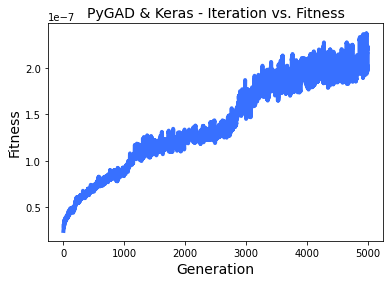

5217991.0
5199733.0
5318983.0
5190616.5
5090856.0
40376520.0
5054819.0
5018910.5
5090856.0
5263776.0
8112736.5
5355947.5
5108922.0
5045830.0
5018910.5
5154228.0
5282146.0
4956380.5
5108922.0
5780615.0
Fitness value of the best solution = 2.0176013524385387e-07
Index of the best solution : 17


In [113]:

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)

#remove if using acc matrix as fitness instead])
#acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
#print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
#print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

#acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
#print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
#print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

In [114]:
acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), tf.argmax(y_train, axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

Accuracy on testing set:93.96799802780151%
Error rate on testing set:6.032001972198486%
Accuracy on training set:86.73856854438782%
Error rate on training set:13.261431455612183%
